In [102]:
import pandas as pd
import lightgbm as lgb 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve

In [103]:
df_race = pd.read_csv("../data/processed.csv", parse_dates=['date','datetime'])

In [104]:
train = df_race.loc[(df_race.date < '2020-01-01')].copy()
val = df_race.loc[(df_race.date < '2021-01-01') & (df_race.date >= '2020-01-01')].copy()
test = df_race.loc[(df_race.date >= '2021-01-01') & (df_race.date < '2021-12-01')].copy()

not_features = ['race_id','date','datetime','finish_pos','won','price','horse_name','finish_pos']

In [105]:
y_rank = train["finish_pos"]
y = train['won']
skf = StratifiedKFold(n_splits=4)
oof = np.zeros(len(train))

callbacks = [lgb.early_stopping(40, verbose=0), lgb.log_evaluation(period=0)]

rank_params = {
    'boost_from_average':False,
    'num_leaves': 64,
    'objective': 'lambdarank',
    'num_threads': 7,
    'eta': 0.02,
    'bagging_fraction': 0.9,
    'bagging_freq': 4,
    'max_depth': 12,
    "lambda_l2":0,
    "drop_rate":0,
    'min_data_in_leaf': 3000,
    'force_col_wise':True
    }

for train_index, test_index in skf.split(train,y):
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train_rank, y_val_rank = y_rank.iloc[train_index], y_rank.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    q_train = X_train["race_id"].value_counts()[X_train["race_id"].unique()]
    q_val = X_val["race_id"].value_counts()[X_val["race_id"].unique()]

    X_train = X_train.drop(columns=not_features)
    X_val = X_val.drop(columns=not_features)

    dtrain = lgb.Dataset(X_train,label = y_train_rank,free_raw_data=False,
                            group = q_train)
    dval = lgb.Dataset(X_val,label = y_val_rank,free_raw_data=False,
                            group = q_val,reference=dtrain)
    
    model = lgb.train(rank_params,
                    dtrain,
                    valid_sets=[dtrain, dval],
                    num_boost_round=200,
                    callbacks = callbacks
                )
    
    y_pred = -model.predict(X_val)    
    oof[test_index] = y_pred

[LightGBM] [Info] Total Bins 40434
[LightGBM] [Info] Number of data points in the train set: 486407, number of used features: 172
[LightGBM] [Info] Total Bins 40425
[LightGBM] [Info] Number of data points in the train set: 486407, number of used features: 172
[LightGBM] [Info] Total Bins 40434
[LightGBM] [Info] Number of data points in the train set: 486407, number of used features: 172
[LightGBM] [Info] Total Bins 40396
[LightGBM] [Info] Number of data points in the train set: 486408, number of used features: 172


In [106]:
# #Train final model on full training set
y_train_rank = train['finish_pos']
y_val_rank = val['finish_pos']

X_train = train.drop(columns=not_features)
X_val = val.drop(columns=not_features)
X_test = test.drop(columns=not_features)

q_train = train["race_id"].value_counts()[train["race_id"].unique()]
q_val = val["race_id"].value_counts()[val["race_id"].unique()]

dtrain = lgb.Dataset(X_train,label = y_train_rank,free_raw_data=False,
                            group = q_train)
dval = lgb.Dataset(X_val,label = y_val_rank,free_raw_data=False,
                            group = q_val,reference=dtrain)

lgbst_rank = lgb.train(rank_params,
                    dtrain,
                    valid_sets=[dtrain, dval],
                    num_boost_round=200,
                    callbacks = callbacks
                )

train["rank"] = oof
train["prob"] = train[["race_id","rank"]].groupby("race_id")["rank"].apply(lambda x: np.exp(x)/sum(np.exp(x)))

val["rank"] =  -lgbst_rank.predict(X_val)
val["prob"] = val[["race_id","rank"]].groupby("race_id")["rank"].apply(lambda x: np.exp(x)/sum(np.exp(x)))


test["rank"] =  -lgbst_rank.predict(X_test)
test["prob"] = test[["race_id","rank"]].groupby("race_id")["rank"].apply(lambda x: np.exp(x)/sum(np.exp(x)))

[LightGBM] [Info] Total Bins 40432
[LightGBM] [Info] Number of data points in the train set: 648543, number of used features: 172


In [107]:
X_train = train.drop(columns=not_features)
X_val = val.drop(columns=not_features)
X_test = test.drop(columns=not_features)

In [117]:
y_train = train['won']
y_val = val['won']
y_test = test['won']
callbacks = [ lgb.log_evaluation(period=50)]

params = {
            'boost_from_average':False,
            'num_leaves': 64,
            'objective': 'binary',
            'num_threads': 7,
            'eta': 0.04,
            'bagging_fraction': 0.9,
            'bagging_freq': 2,
            'max_depth': 16,
            "lambda_l2":0,
            "drop_rate":0.3,
            'min_data_in_leaf': 3000,
            "metric":'binary_logloss',
            'force_col_wise':True
            }

train_lgb = lgb.Dataset(X_train,label = y_train,free_raw_data=False)
val_lgb = lgb.Dataset(X_val,label = y_val,free_raw_data=False,reference = train_lgb)

lgbst = lgb.train(train_set = train_lgb,params = params, valid_sets=val_lgb,
                     num_boost_round=400, callbacks=callbacks)

[LightGBM] [Info] Number of positive: 69689, number of negative: 578854
[LightGBM] [Info] Total Bins 40942
[LightGBM] [Info] Number of data points in the train set: 648543, number of used features: 174
[50]	valid_0's binary_logloss: 0.307424
[100]	valid_0's binary_logloss: 0.287722
[150]	valid_0's binary_logloss: 0.2865
[200]	valid_0's binary_logloss: 0.286279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's binary_logloss: 0.28622
[300]	valid_0's binary_logloss: 0.286189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's binary_logloss: 0.286261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's binary_logloss: 0.286363


In [118]:
def bet_simulate(t, kelly_min, prob_min ,starting_balance):
    trial = df_race.loc[t.index,["race_id","last_price","won","date","price"]].copy()

    trial["pred_prob"] =lgbst.predict(t)
    trial["pred_sp"] = 1/trial["pred_prob"]
    trial["kelly"] = ((trial["pred_prob"]*trial["last_price"]) - 1)/(trial["last_price"] - 1)
    
    trial["bet"] = (trial["pred_prob"] > prob_min)  & (trial['kelly'] > kelly_min)
    isnoise = [len(str(i)) > 5 for i in trial["last_price"]]
    #trial.loc[isnoise,"last_price"] = trial.loc[isnoise,"dec"]
    trial["winnings"] = (trial['bet'] * trial["kelly"] * starting_balance * trial["last_price"] * trial["won"] * 0.95) - (trial['bet'] * trial["kelly"] * starting_balance)
    trial["bank"] = trial["winnings"].cumsum()
    trial["bet size"] = trial["bet"]*trial["kelly"]*starting_balance

    return trial

def evaluate(t,prob_min = 0.2,kelly_min = 0.05):


    t = bet_simulate(t,prob_min=prob_min,kelly_min=kelly_min ,starting_balance = 500)

    roi = sum(t["winnings"])/sum(t["bet"] * t["kelly"] * 500)
    sr = sum((t['bet']) & (t['won']))/sum(t["bet"])

    final_balance = round(int(t['bank'][-1:]),2)
    bets_per_day = round(sum(t['bet'])/len(t['date'].unique()),2)
    ROI = round(roi*100,2)
    SR = round(sr*100,2)
    min_balance = round(min(t["bank"]),2) + 500 
    avg_bet_size = round(t.loc[t['bet'] ==1,"bet size"].mean(),2)
    max_bet = round(t.loc[t['bet'] ==1,"bet size"].max(),2)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plot = plt.plot(t['date'],t['bank'], label = "prob:" + str(prob_min)+ " kelly:" + str(kelly_min))
    plt.legend()
    out = {'prob_min':prob_min,
           'kelly_min':kelly_min,
           'final_balance':final_balance,
           'bets_per_day':bets_per_day,
           'ROI':ROI,
           'SR':SR,
           'min_balance':min_balance,
           'avg_bet_size':avg_bet_size,
           'max_bet':max_bet}

    return out,plot


,prob_min,kelly_min,final_balance,bets_per_day,ROI,SR,min_balance,avg_bet_size,max_bet
0,0.1,0.00,36399,37.70,16.45,19.80,493.76,21.43,213.12
1,0.1,0.01,37063,30.93,17.10,20.98,493.76,25.57,213.12
2,0.1,0.02,37041,24.21,18.25,22.28,500.00,30.60,213.12
3,0.1,0.03,35492,18.27,19.42,24.01,500.00,36.50,213.12
4,0.1,0.04,34649,13.75,21.50,26.41,500.00,42.79,213.12
5,0.2,0.00,24709,14.65,17.48,31.04,500.00,35.21,213.12
6,0.2,0.01,24754,13.44,17.62,31.50,500.00,38.15,213.12
7,0.2,0.02,24806,12.01,18.03,31.98,500.00,41.81,213.12
8,0.2,0.03,24380,10.49,18.43,32.43,500.00,46.04,213.12
9,0.2,0.04,23826,9.07,18.98,33.07,500.00,50.49,213.12


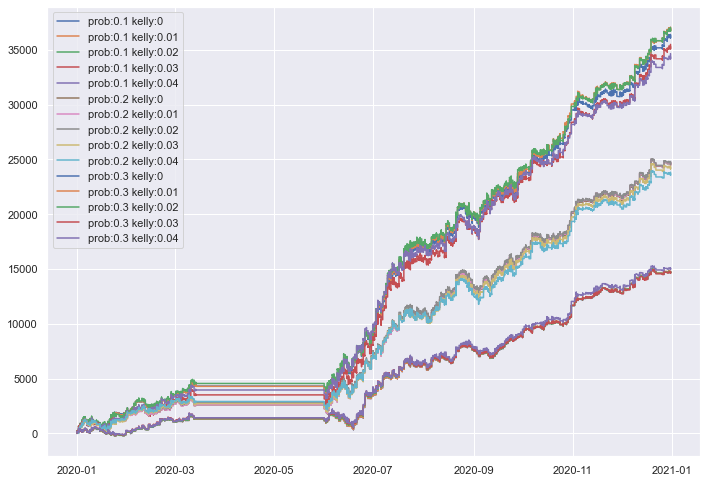

In [119]:
outs = []
params = []
for i in [0.1,0.2,0.3]:
    for j in [0,0.01,0.02,0.03,0.04]:
        params.append([i,j])
        outs.append(evaluate(X_val,prob_min=i, kelly_min = j))


pd.DataFrame([d[0] for d in outs])

,prob_min,kelly_min,final_balance,bets_per_day,ROI,SR,min_balance,avg_bet_size,max_bet
14,0.3,0.04,14569,5.30,14.26,40.29,384.00,62.20,241.39
13,0.3,0.03,14333,5.77,13.69,39.99,360.97,58.58,241.39
12,0.3,0.02,14302,6.20,13.44,39.73,338.99,55.35,241.39
9,0.2,0.04,20600,10.07,13.29,31.21,54.04,49.68,241.39
11,0.3,0.01,14170,6.63,13.19,39.27,312.79,52.28,241.39
10,0.3,0.00,14164,7.08,13.14,39.15,306.30,49.13,241.39
8,0.2,0.03,20743,11.77,12.62,30.69,49.40,45.03,241.39
7,0.2,0.02,20814,13.49,12.17,30.12,3.67,40.88,241.39
4,0.1,0.04,23428,15.18,11.77,24.61,337.61,42.28,241.39
6,0.2,0.01,20569,15.17,11.76,29.54,-47.36,37.20,241.39


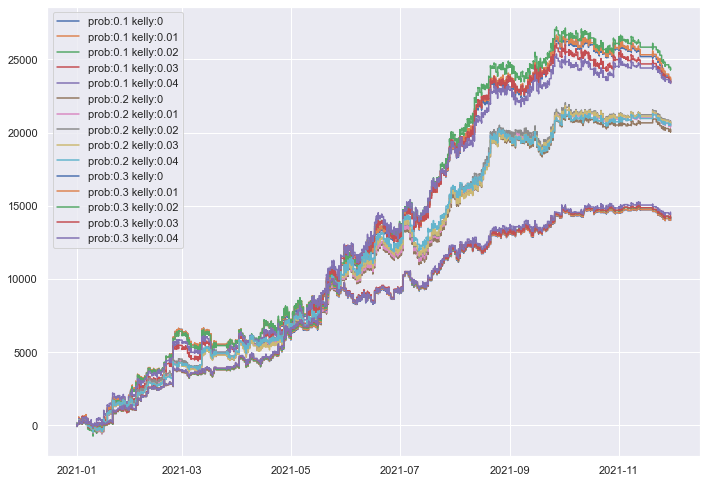

In [120]:
outs = []
params = []
for i in [0.1,0.2,0.3]:
    for j in [0,0.01,0.02,0.03,0.04]:
        params.append([i,j])
        outs.append(evaluate(X_test,prob_min=i, kelly_min = j))


pd.DataFrame([d[0] for d in outs]).sort_values(by = 'ROI',ascending=False)

Model val log-loss =  0.30052041741858426 SP val log-loss =  0.30028667093141304


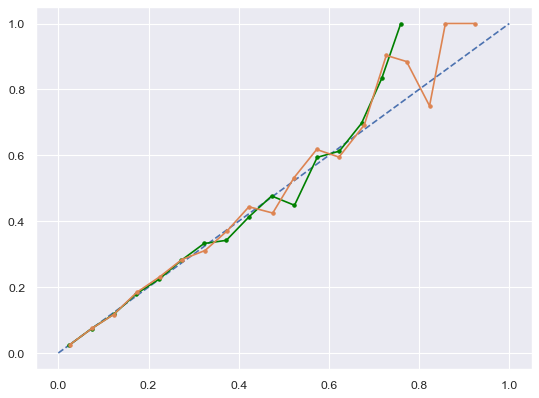

In [112]:
print("Model val log-loss = ", log_loss(y_test,lgbst.predict(X_test)), "SP val log-loss = ", log_loss(y_test, 1/df_race.loc[X_test.index,"last_price"]))
plt.figure(figsize=(8, 6), dpi=80)
fop, mpv = calibration_curve(y_test, 1/df_race.loc[X_test.index,"last_price"],n_bins=20)
fop1, mpv1 = calibration_curve(y_test,lgbst.predict(X_test),n_bins=20)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv1, fop1, marker='.', color = "green")
plt.plot(mpv, fop, marker='.')

plt.show()